# Fine-grained Fruits-360 Pipeline
This notebook starts from the fine-grained dataloader (1.1) and adds EDA, color-hist features, PCA exploration, and classic ML models.

In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from utils.pipeline_utils import (
    AugmentedDatasetWrapper,
    FruitFolderDataset,
    color_hist_features,
    dataloader_to_numpy,
    download_dataset,
    save_checkpoint,
 )

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Download and setup dataset
Clone Fruits-360 dataset, organize into train/test folders, verify file structure. Download only runs if dataset not already present locally.

In [ ]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

if not os.path.exists(ROOT_DIR):
    download_dataset(ROOT_DIR, TRAIN_DIR, TEST_DIR, GITHUB_REPO, CLONE_DIR)

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")

Train dir: dataset/fruit360/Training
Test dir: dataset/fruit360/Test


## Configuration parameters
Define image size, batch size, and noise configuration. Three noise levels: `augment_prob=0.1` (light), `0.2` (medium), `0.3` (heavy). Higher probability = more frequent augmentation.

## Load dataset and create base splits
Create FruitFolderDataset for training and test. Use fine-grained variety labels (`variety=True`). Set random seed for reproducibility.

**Change here:** `variety=False` if you want coarse fruit labels instead of fine-grained variety labels; `RANDOM_STATE` for different train/val splits.

## Create checkpoint directories
Prepare paths for saving trained models and metadata under `artifacts/checkpoints/fruit360/level_of_noise/`.

In [5]:
size = 32
batch = 128
RANDOM_STATE = 42

## Create train/val splits with augmentation
Split training data into train and validation sets. Each split uses AugmentedDatasetWrapper with the noise configuration applied during training (val/test have no augmentation).

## Create DataLoaders
Wrap datasets in DataLoader with batching and shuffling. Training dataloader is shuffled; validation/test are ordered for reproducibility.

In [7]:
val_transform = T.Compose([
    T.Resize((size, size)),
    T.ToTensor()
])

full_train_dataset_fg = FruitFolderDataset(TRAIN_DIR, transform=val_transform, variety=False)
test_dataset_fg = FruitFolderDataset(TEST_DIR, transform=val_transform, variety=False)

train_size_fg = int(0.7 * len(full_train_dataset_fg))
val_size_fg = len(full_train_dataset_fg) - train_size_fg

train_dataset_fg, val_dataset_fg = random_split(
    full_train_dataset_fg,
    [train_size_fg, val_size_fg],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

aug_train_dataset_fg = AugmentedDatasetWrapper(
    train_dataset_fg,
    augment_prob=0.5,
    max_augmentations=2,
    use_scenarios=False,
 )

train_loader_fg = DataLoader(aug_train_dataset_fg, batch_size=batch, shuffle=True)
val_loader_fg = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader_fg = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

print("All -> Train:", len(train_dataset_fg),
      "Val:", len(val_dataset_fg),
      "Test:", len(test_dataset_fg),
      "Classes:", len(full_train_dataset_fg.label_to_idx))

Training -> 130344 images, 79 classes
Test -> 43442 images, 79 classes
All -> Train: 91240 Val: 39104 Test: 43442 Classes: 79


## Convert to NumPy and extract features
Batch all images into NumPy arrays. Compute color histogram features with 32 bins. Results stored in `X_train_hist`, `X_val_hist`, `X_test_hist`.

In [ ]:
X_train_np, y_train_np = dataloader_to_numpy(train_loader_fg)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_fg)
X_test_np, y_test_np = dataloader_to_numpy(test_loader_fg)

print("Train:", X_train_np.shape, y_train_np.shape)
print("Val:", X_val_np.shape, y_val_np.shape)
print("Test:", X_test_np.shape, y_test_np.shape)

Train: (91240, 3, 32, 32) (91240,)
Val: (39104, 3, 32, 32) (39104,)
Test: (43442, 3, 32, 32) (43442,)


## Exploratory Data Analysis (EDA)
Show sample images from train, val, and test sets. Verify dataset shapes and label distributions. Helps confirm augmentation is not applied during visualization.

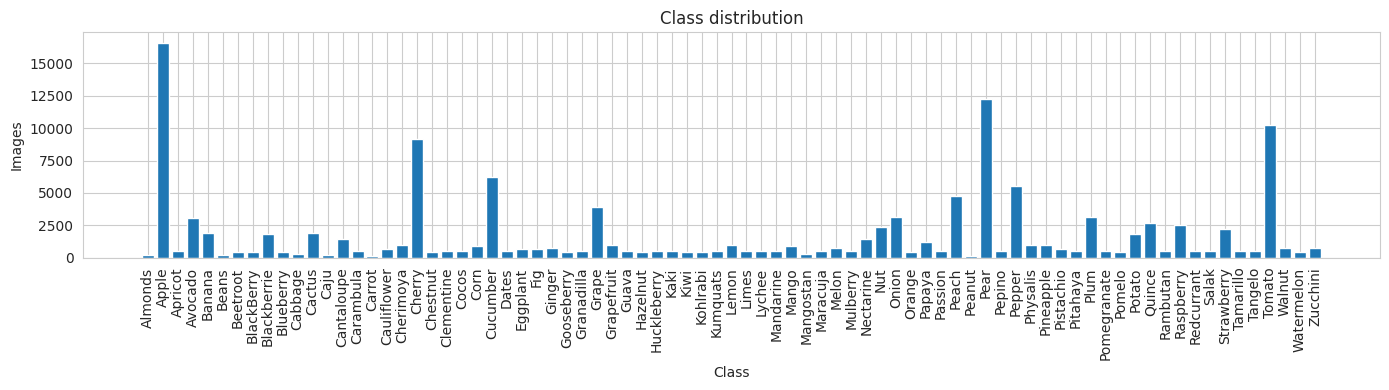

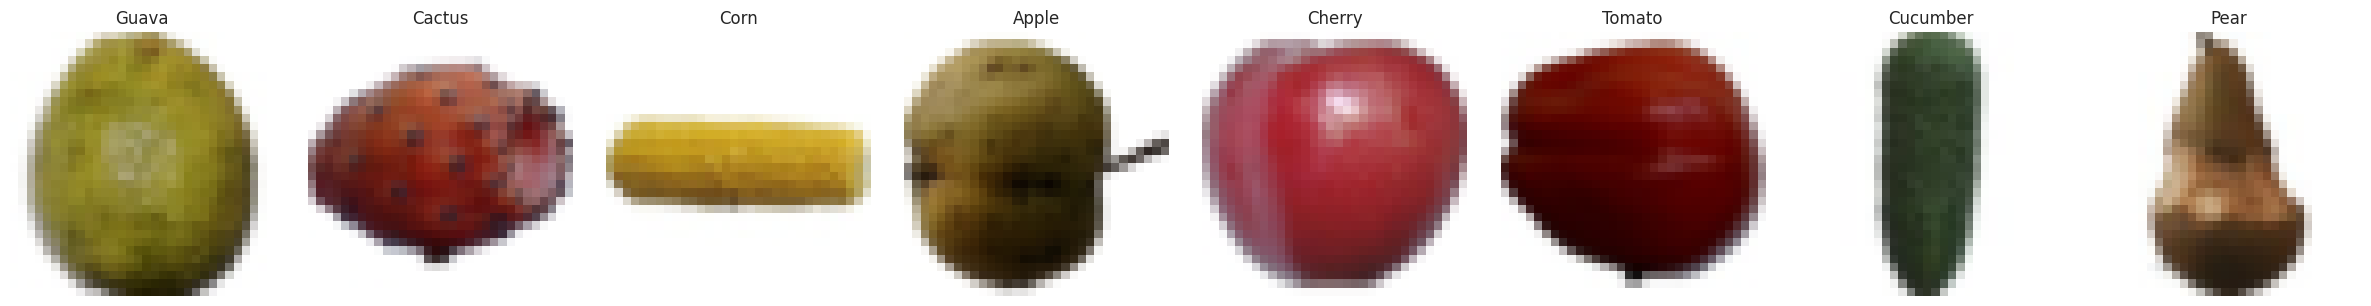

In [9]:
label_counts = {}
for _, lbl in full_train_dataset_fg.samples:
    label_counts[lbl] = label_counts.get(lbl, 0) + 1

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random sample images
n_show = 8
indices = random.sample(range(len(train_dataset_fg)), n_show)
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
for ax, idx in zip(axes, indices):
    img, label_idx = train_dataset_fg[idx]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_train_dataset_fg.idx_to_label[int(label_idx)])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Standardize features
Fit StandardScaler on training features and apply to train/val/test. Scaling improves SVM performance. Scaler is saved with checkpoint for later inference.

In [ ]:
X_train_color = color_hist_features(X_train_np, bins=16, img_shape=(3, size, size))
X_val_color   = color_hist_features(X_val_np,   bins=16, img_shape=(3, size, size))
X_test_color  = color_hist_features(X_test_np,  bins=16, img_shape=(3, size, size))

print(X_train_color.shape)
print(X_val_color.shape)
print(X_test_color.shape)

(91240, 48)
(39104, 48)
(43442, 48)


## Grid search: Noise level vs SVM hyperparameter
Train SVM models across all combinations of: augmentation probability (0.1, 0.2, 0.3) and C values (hyperparameter). Evaluates validation accuracy for each combination. Results saved to CSV and models checkpointed.

**Change here:** `C_list` to test different SVM regularization strengths; `augment_prob` values in `noise_configs` to modify noise intensity sweep.

In [12]:
# Grid di configurazioni per augmentation e training
run_names = [
    "01_noise",
    "02_noise",
    "03_noise",
]

noise_configs = [
    {"name": "01_noise", "augment_prob": 0.1, "max_augmentations": 1, "use_scenarios": True, "scenario_weights": [0.4, 0.4, 0.2]},
    {"name": "02_noise", "augment_prob": 0.2, "max_augmentations": 1, "use_scenarios": True, "scenario_weights": [0.4, 0.4, 0.2]},
    {"name": "03_noise", "augment_prob": 0.3, "max_augmentations": 1, "use_scenarios": True, "scenario_weights": [0.4, 0.4, 0.2]},
]

def make_train_loader(cfg):
    aug_ds = AugmentedDatasetWrapper(
        train_dataset_fg,
        augment_prob=cfg["augment_prob"],
        max_augmentations=cfg["max_augmentations"],
        use_scenarios=cfg["use_scenarios"],
        scenario_weights=cfg.get("scenario_weights"),
    )
    return DataLoader(aug_ds, batch_size=batch, shuffle=True)

def compute_color_features_from_loader(loader):
    X_np, y_np = dataloader_to_numpy(loader)
    X_color = color_hist_features(X_np, bins=16, img_shape=(3, size, size))
    return X_color, y_np

val_loader = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)
X_val_color, y_val = compute_color_features_from_loader(val_loader)
X_test_color, y_test = compute_color_features_from_loader(test_loader)

k_list = [5, 7, 9, 11]
C_list = [10, 20, 40]
rf_depth_list = [20, 30, 40]

results_grid = []
model_out_root = CKPT_ROOT / "fruit360"
model_out_root.mkdir(parents=True, exist_ok=True)

for cfg in noise_configs:
    train_loader_cfg = make_train_loader(cfg)
    X_train_color, y_train = compute_color_features_from_loader(train_loader_cfg)

    scaler = StandardScaler()
    X_train_color_std = scaler.fit_transform(X_train_color)
    X_val_color_std = scaler.transform(X_val_color)
    X_test_color_std = scaler.transform(X_test_color)

    meta_base = {
        "task": "fruit360",
        "split": "All",
        "feature": "color_hist",
        "img_size": size,
        "bins": 16,
        "seed": RANDOM_STATE,
        "n_classes": len(full_train_dataset_fg.label_to_idx),
        "labels": full_train_dataset_fg.labels,
        "label_to_idx": full_train_dataset_fg.label_to_idx,
        "noise_cfg": cfg,
    }

    # kNN
    best_knn_acc = 0.0
    best_k = None
    best_knn_model = None
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_color_std, y_train)
        y_val_pred = knn.predict(X_val_color_std)
        acc = accuracy_score(y_val, y_val_pred)
        if acc > best_knn_acc:
            best_knn_acc = acc
            best_k = k
            best_knn_model = knn
    if best_knn_model is not None:
        y_test_pred = best_knn_model.predict(X_test_color_std)
        test_acc = accuracy_score(y_test, y_test_pred)
        run_dir = model_out_root / cfg["name"] / "knn"
        save_checkpoint(
            best_knn_model,
            scaler,
            {**meta_base, "model": f"knn-{cfg['name']}", "params": {"n_neighbors": best_k}},
            run_dir=run_dir,
            save_meta=False,
        )
        results_grid.append({"cfg": cfg["name"], "model": "knn", "val_acc": best_knn_acc, "test_acc": test_acc})

    # SVM
    best_svm_acc = 0.0
    best_C = None
    best_svm_model = None
    for C in C_list:
        svm = SVC(kernel="rbf", gamma='scale', C=C)
        svm.fit(X_train_color_std, y_train)
        y_val_pred = svm.predict(X_val_color_std)
        acc = accuracy_score(y_val, y_val_pred)
        if acc > best_svm_acc:
            best_svm_acc = acc
            best_C = C
            best_svm_model = svm
    if best_svm_model is not None:
        y_test_pred = best_svm_model.predict(X_test_color_std)
        test_acc = accuracy_score(y_test, y_test_pred)
        run_dir = model_out_root / cfg["name"] / "svm"
        save_checkpoint(
            best_svm_model,
            scaler,
            {**meta_base, "model": f"svm-{cfg['name']}", "params": {"kernel": "rbf", "C": best_C, "gamma": "scale"}},
            run_dir=run_dir,
            save_meta=False,
        )
        results_grid.append({"cfg": cfg["name"], "model": "svm", "val_acc": best_svm_acc, "test_acc": test_acc})

print(results_grid)

[{'cfg': '01_noise', 'model': 'knn', 'val_acc': 0.9996164075286416, 'test_acc': 0.9824363519174992}, {'cfg': '01_noise', 'model': 'svm', 'val_acc': 0.9999744271685761, 'test_acc': 0.9848073293126467}, {'cfg': '02_noise', 'model': 'knn', 'val_acc': 0.999488543371522, 'test_acc': 0.9813544496109755}, {'cfg': '02_noise', 'model': 'svm', 'val_acc': 0.9999232815057283, 'test_acc': 0.9846461949265688}, {'cfg': '03_noise', 'model': 'knn', 'val_acc': 0.9995908346972177, 'test_acc': 0.9804336816905299}, {'cfg': '03_noise', 'model': 'svm', 'val_acc': 0.9999232815057283, 'test_acc': 0.9847843101146356}]
